In [ ]:
# GOLLA SAHITHI

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [22]:
# Loading dataset
df = pd.read_csv('Siemens_Predictive_Maintainance_Dataset.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [23]:
print(df.columns.tolist())

['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


In [24]:
# Droping non-informative columns
df.drop(columns=['UDI', 'Product ID'], inplace=True)

# One hot encoding
df = pd.get_dummies(df, columns=['Type'], drop_first=True)

print(df.head())

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  \
0         42.8                0                0    0    0    0    0    0   
1         46.3                3                0    0    0    0    0    0   
2         49.4                5                0    0    0    0    0    0   
3         39.5                7                0    0    0    0    0    0   
4         40.0                9                0    0    0    0    0    0   

   Type_L  Type_M  
0   False    True  
1    True   False  
2    True   False  
3    T

In [25]:
# Basic structure
print("Shape of dataset:", df.shape)
print("\nColumn data types:\n", df.dtypes)

# Missing values
print("\nMissing values:\n", df.isnull().sum())

# Target distribution
print("\nTarget class distribution (Machine failure):\n", df['Machine failure'].value_counts())

Shape of dataset: (10000, 13)

Column data types:
 Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
Type_L                        bool
Type_M                        bool
dtype: object

Missing values:
 Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
Type_L                     0
Type_M                     0
dtype: int64

Target class distribution (Machine failure):
 Machine failure
0    9661

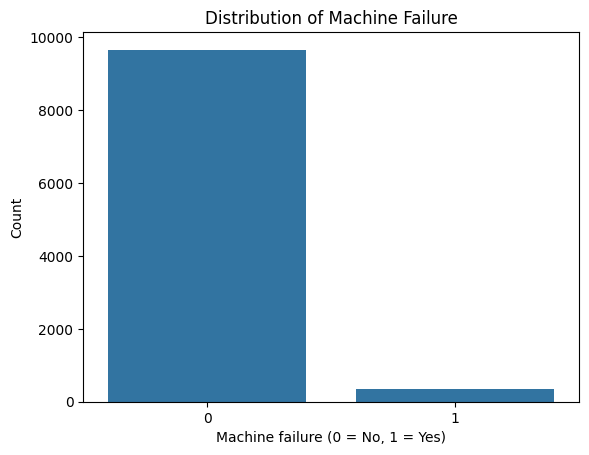

In [26]:
# Machine failure count
sns.countplot(x='Machine failure', data=df)
plt.title("Distribution of Machine Failure")
plt.xlabel("Machine failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

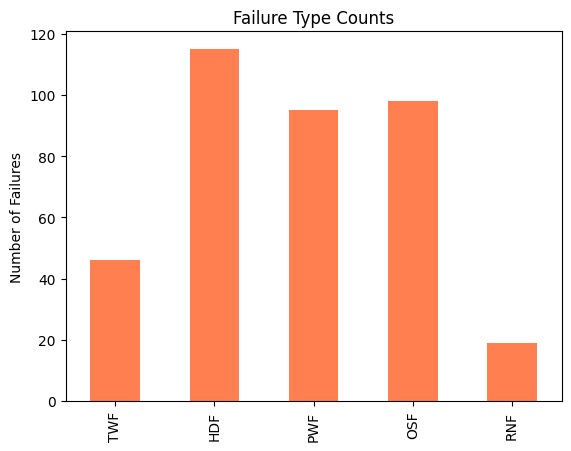

In [27]:
# Individual failure type columns
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df[failure_types].sum().plot(kind='bar', color='coral')
plt.title("Failure Type Counts")
plt.ylabel("Number of Failures")
plt.show()

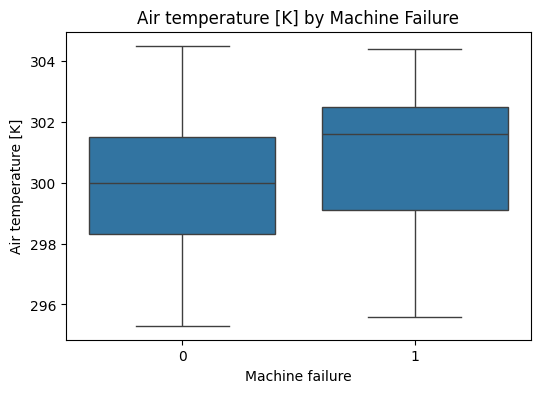

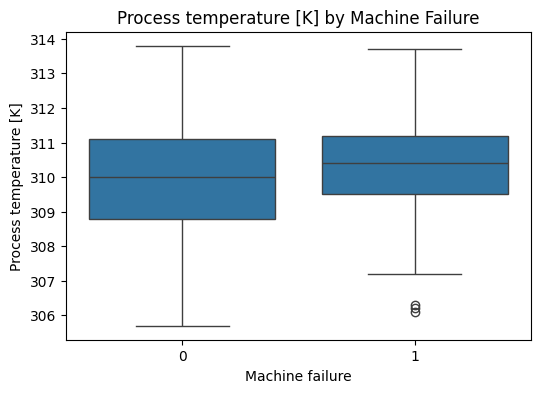

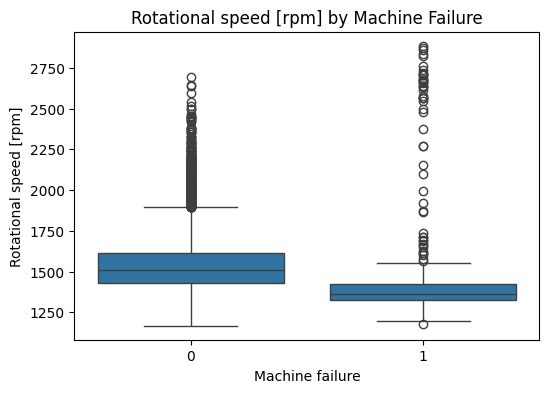

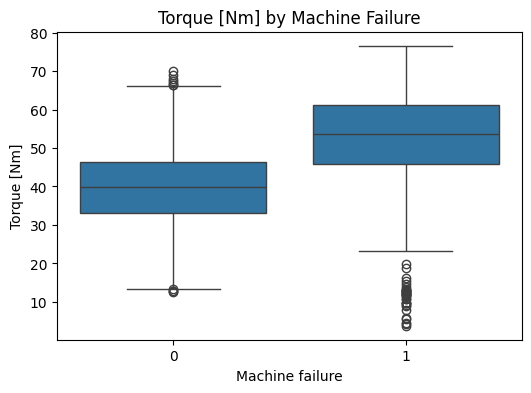

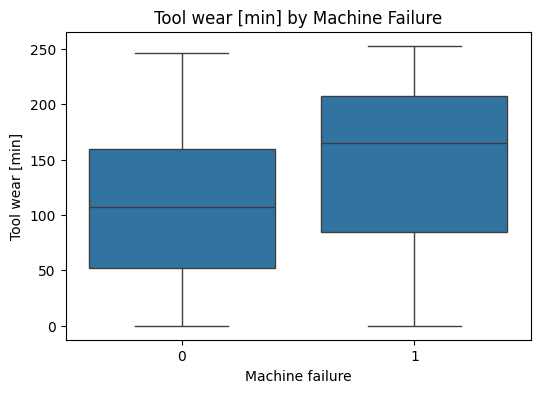

In [28]:
for col in sensor_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Machine failure', y=col, data=df)
    plt.title(f'{col} by Machine Failure')
    plt.show()

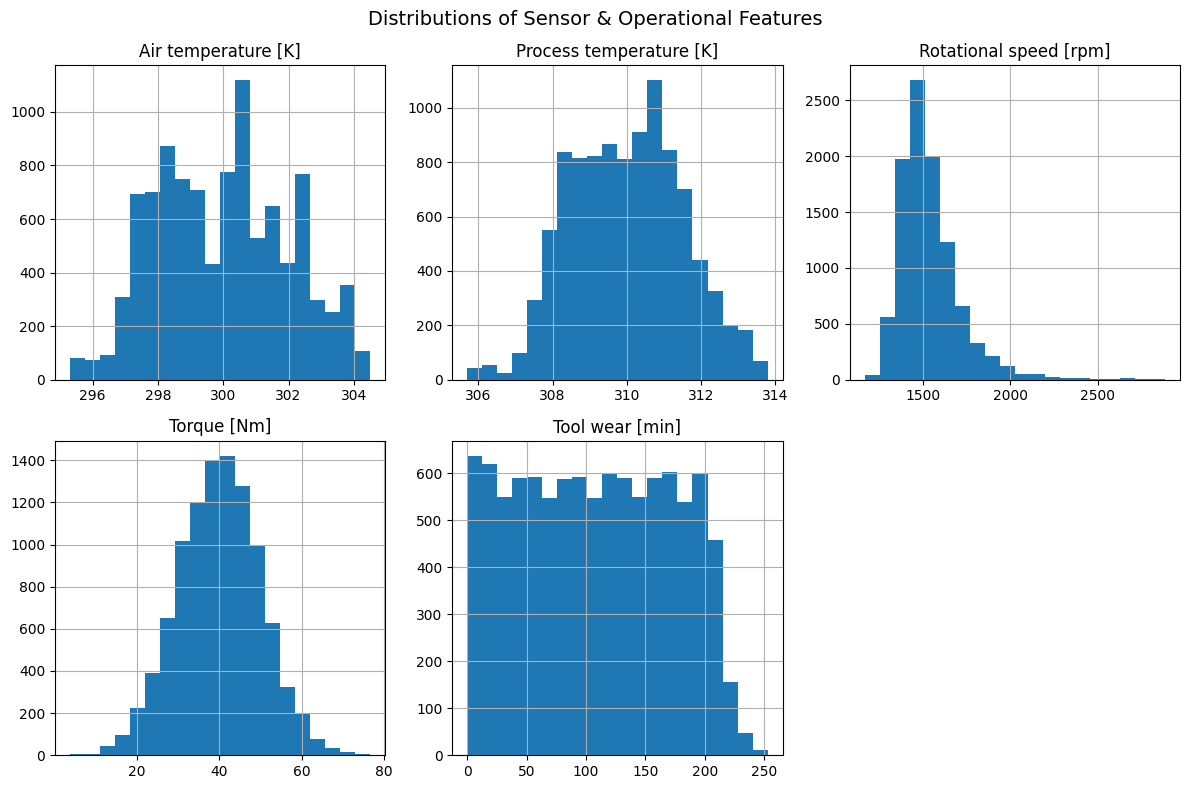

In [29]:
sensor_cols = [
    'Air temperature [K]', 'Process temperature [K]',
    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'
]

df[sensor_cols].hist(bins=20, figsize=(12, 8), layout=(2, 3))
plt.suptitle("Distributions of Sensor & Operational Features", fontsize=14)
plt.tight_layout()
plt.show()

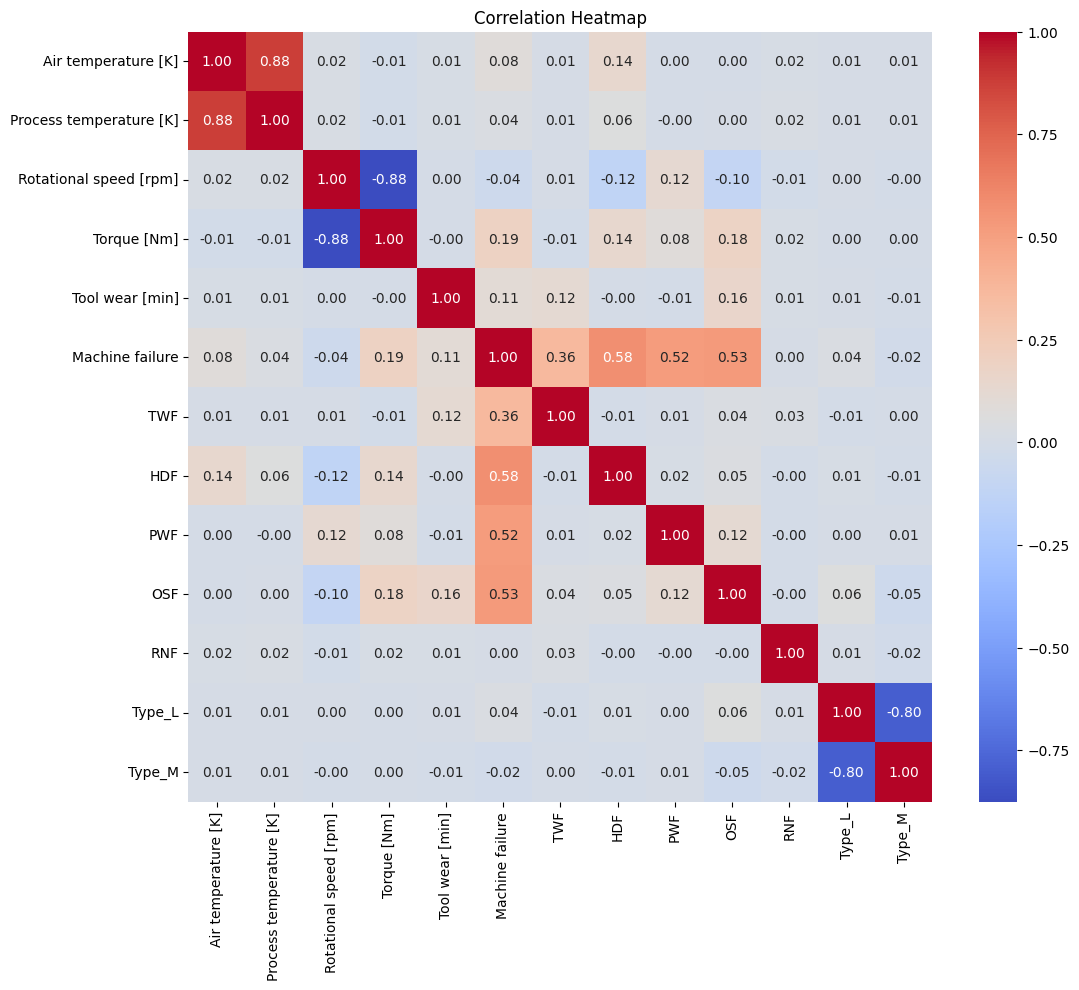

In [30]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [32]:
df['Machine failure'].value_counts(normalize=True)

Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64

In [34]:
from sklearn.utils import resample

# Separate classes
df_majority = df[df['Machine failure'] == 0]
df_minority = df[df['Machine failure'] == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority, 
    replace=True, 
    n_samples=len(df_majority), 
    random_state=42
)

# Combine and shuffle
df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm new balance
print(df_balanced['Machine failure'].value_counts(normalize=True))


Machine failure
0    0.5
1    0.5
Name: proportion, dtype: float64


In [35]:
# Feature Engineering
# Feature: Temperature difference
df['Temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']

# Feature: Torque per RPM
df['Torque_per_rpm'] = df['Torque [Nm]'] / df['Rotational speed [rpm]']

# Feature: Wear per torque
df['Wear_per_torque'] = df['Tool wear [min]'] / df['Torque [Nm]']

df.replace([float('inf'), -float('inf')], 0, inplace=True)
df.fillna(0, inplace=True)

from sklearn.preprocessing import StandardScaler

scale_cols = [
    'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
    'Torque [Nm]', 'Tool wear [min]', 'Temp_diff', 'Torque_per_rpm', 'Wear_per_torque'
]

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

In [36]:
# Train-Test Split
from sklearn.model_selection import train_test_split

# Defining target variable
y = df['Machine failure']

X = df.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (8000, 10)
Test set: (2000, 10)


In [37]:
# Training Mpdels
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Logistic Regression model:\n", logreg)
print("\nRandom Forest model:\n", rf)

Logistic Regression model:
 LogisticRegression(max_iter=1000, random_state=42)

Random Forest model:
 RandomForestClassifier(random_state=42)


In [38]:
# Cross Validation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression - AUC score
logreg_cv_scores = cross_val_score(
    logreg, X_train, y_train, 
    cv=cv, scoring='roc_auc'
)

# Random Forest - AUC score
rf_cv_scores = cross_val_score(
    rf, X_train, y_train, 
    cv=cv, scoring='roc_auc'
)

print("Cross-Validation Results (ROC-AUC):\n")

print("Logistic Regression AUC Scores:", logreg_cv_scores)
print("Mean AUC (LogReg): {:.4f}".format(logreg_cv_scores.mean()))

print("\nRandom Forest AUC Scores:", rf_cv_scores)
print("Mean AUC (RF): {:.4f}".format(rf_cv_scores.mean()))

Cross-Validation Results (ROC-AUC):

Logistic Regression AUC Scores: [0.94168943 0.89461454 0.90535911 0.91897849 0.91417476]
Mean AUC (LogReg): 0.9150

Random Forest AUC Scores: [0.98624287 0.96904197 0.95881846 0.97044943 0.9587055 ]
Mean AUC (RF): 0.9687


In [39]:
from sklearn.metrics import f1_score, accuracy_score, make_scorer

# Accuracy scores
logreg_acc = cross_val_score(logreg, X_train, y_train, cv=cv, scoring='accuracy')
rf_acc = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')

# F1 scores
logreg_f1 = cross_val_score(logreg, X_train, y_train, cv=cv, scoring='f1')
rf_f1 = cross_val_score(rf, X_train, y_train, cv=cv, scoring='f1')

print("\nLogistic Regression - Accuracy: {:.4f}, F1: {:.4f}".format(logreg_acc.mean(), logreg_f1.mean()))
print("Random Forest - Accuracy: {:.4f}, F1: {:.4f}".format(rf_acc.mean(), rf_f1.mean()))


Logistic Regression - Accuracy: 0.9719, F1: 0.3862
Random Forest - Accuracy: 0.9856, F1: 0.7546



--- Logistic Regression on Test Set ---
Accuracy: 0.9675
F1 Score: 0.2696629213483146
ROC AUC: 0.9252527097795641

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.57      0.18      0.27        68

    accuracy                           0.97      2000
   macro avg       0.77      0.59      0.63      2000
weighted avg       0.96      0.97      0.96      2000



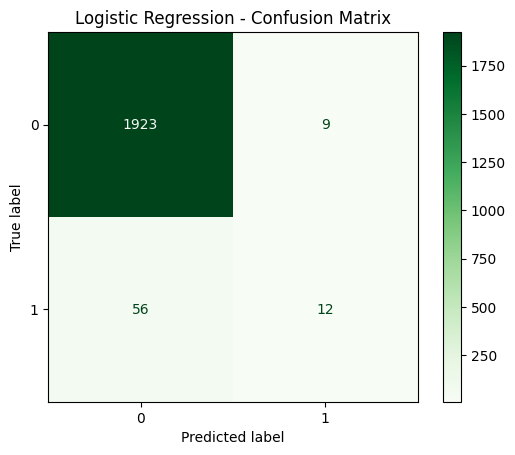


--- Random Forest on Test Set ---
Accuracy: 0.9885
F1 Score: 0.816
ROC AUC: 0.967410333698697

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.89      0.75      0.82        68

    accuracy                           0.99      2000
   macro avg       0.94      0.87      0.91      2000
weighted avg       0.99      0.99      0.99      2000



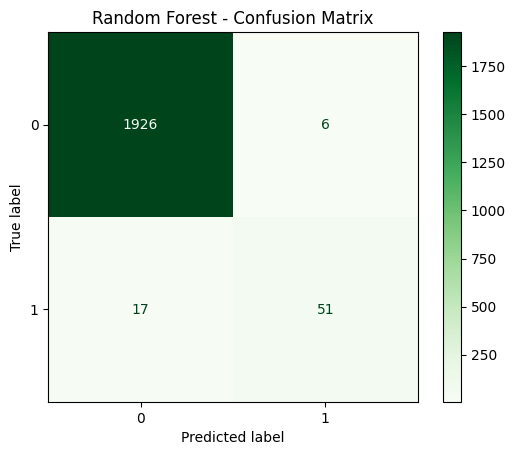

In [45]:
# Model Evaluation
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, ConfusionMatrixDisplay, roc_curve
)
import matplotlib.pyplot as plt

models = {
    'Logistic Regression': logreg,
    'Random Forest': rf
}

for name, model in models.items():
    print(f"\n--- {name} on Test Set ---")
    
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,cmap='Greens')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    

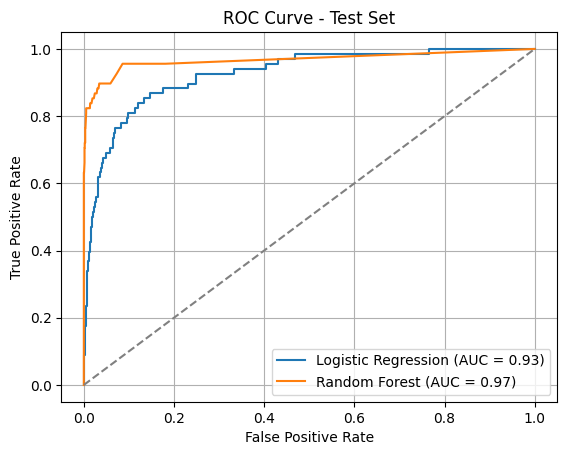

In [46]:
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Model Comparison

comparison_results = []
roc_data = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    comparison_results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'F1 Score': round(f1, 4),
        'ROC AUC': round(auc, 4)
    })

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, auc)

comparison_df = pd.DataFrame(comparison_results)
print("\nModel Comparison Summary:")
print(comparison_df.sort_values(by='ROC AUC', ascending=False))


Model Comparison Summary:
                 Model  Accuracy  F1 Score  ROC AUC
1        Random Forest    0.9885    0.8160   0.9674
0  Logistic Regression    0.9675    0.2697   0.9253


In [48]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\sahit\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [50]:
import shap

# Make sure X_test is a DataFrame with column names
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Use SHAP's TreeExplainer for Random Forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_df)


<Figure size 640x480 with 0 Axes>

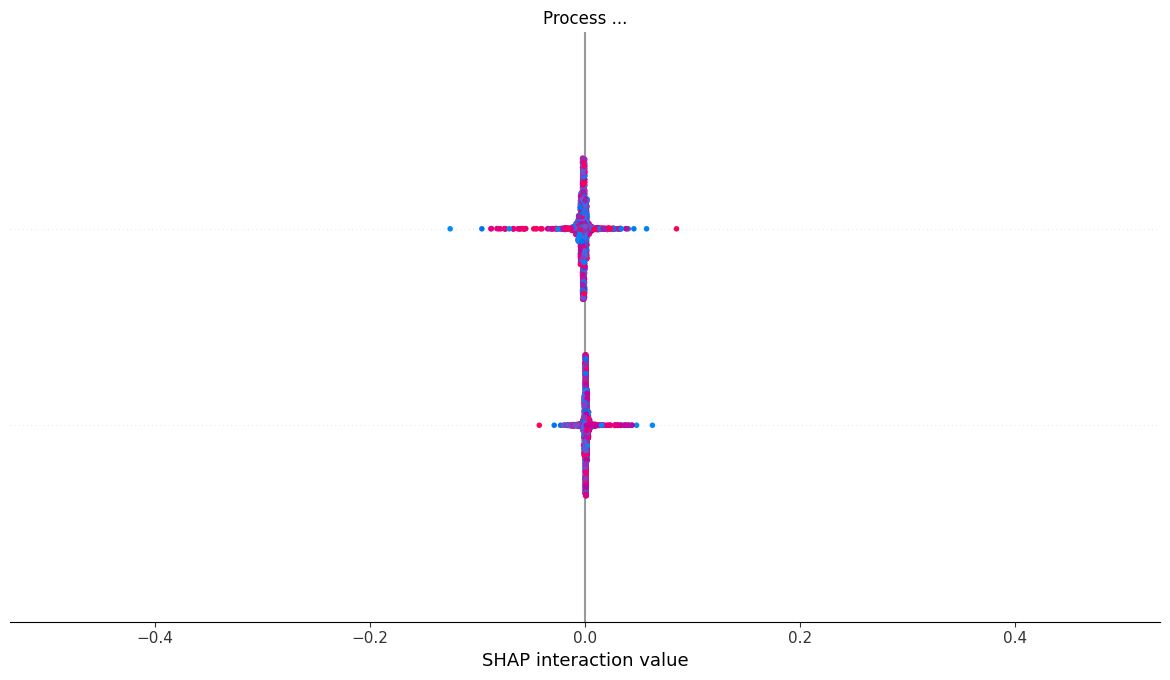

In [56]:
# Bar plot
try:
    shap.summary_plot(shap_values[1], X_test_df, plot_type='bar')
except Exception:
    shap.summary_plot(shap_values, X_test_df, plot_type='bar')

<Figure size 640x480 with 0 Axes>

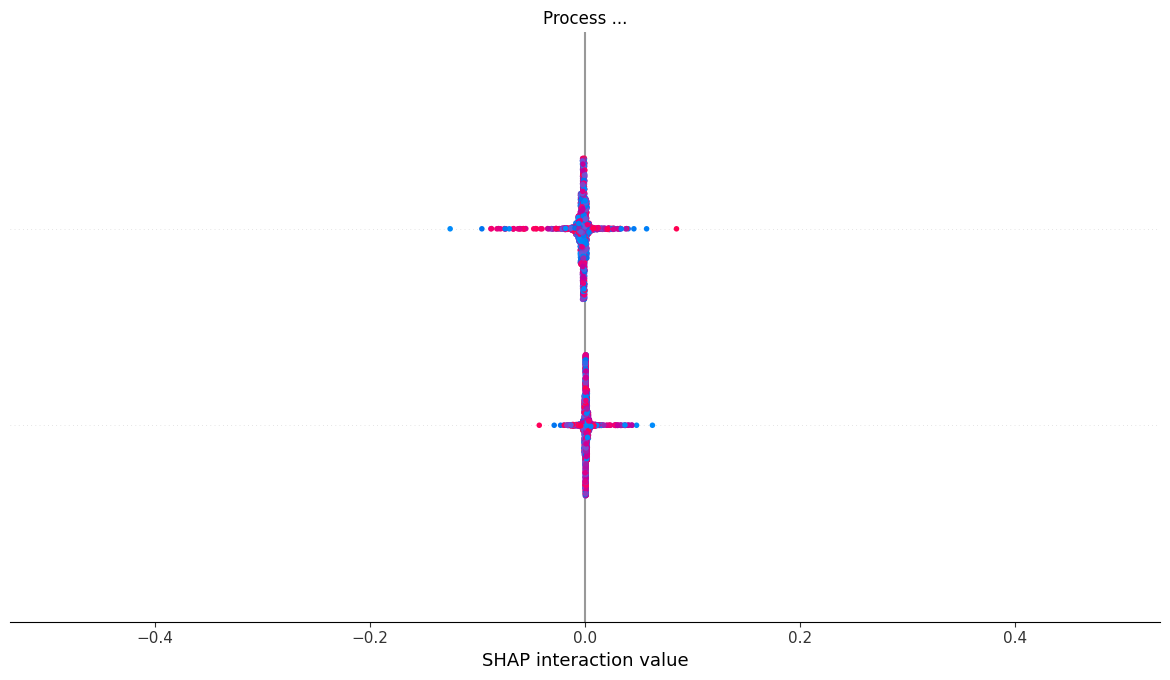

In [55]:
# Beeswarm Plot
try:
    shap.summary_plot(shap_values[1], X_test_df)
except Exception:
    shap.summary_plot(shap_values, X_test_df)